# Overview

This notebook contains my solutions for **<a href="https://adventofcode.com/2017" target="_blank">Advent of Code 2017</a>**.

A few notes...
- **Author: [Dazbo](https://github.com/derailed-dash)**
- The source for this notebook source lives in my GitHub repo, <a href="https://github.com/derailed-dash/Advent-of-Code/blob/master/src/AoC_2017/Dazbo's_Advent_of_Code_2017.ipynb" target="_blank">here</a>.
- You can run this Notebook wherever you like. For example, you could...
  - Run it locally, in your own Jupyter environment.
  - Run it in a cloud-based Jupyter environment, with no setup required on your part!  For example, <a href="https://colab.research.google.com/github/derailed-dash/Advent-of-Code/blob/master/src/AoC_2017/Dazbo's_Advent_of_Code_2017.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Google Colab"/></a>
- **To run the notebook, execute the cells in the [Setup](#Setup) section, as described below. Then you can run the code for any given day.**
- Be mindful that the first time you run this notebook, you will need to **obtain your AoC session key** and store it, if you have not done so already. This allows the notebook to automatically retrieve your input data. (See the guidance in the **[Get Access to Your AoC Data](#Get-Access-to-Your-AoC-Data)** section for details.)
- Use the navigation menu on the left to jump to any particular day.
- All of my AoC solutions are documented in my <a href="https://aoc.just2good.co.uk/" target="_blank">AoC Python Walkthrough site</a>.

## External Dependencies and Pre-Reqs

The easiest way to install the required dependencies is to run this command external to the notebook, before launching it:

```bash
uv sync --dev --extra jupyter
```

Additionally, you may need to install required OS packages for some of the solutions, e.g. for visualisations and animations.

- [ffmpeg](https://ffmpeg.org/): in order to render video output, i.e. for visualisations.
- graphviz: for visualising graphs

In Linux, you may need to install packages manually, as the notebook will often not have necessary permissions to install dependenct packages. E.g.

```bash
sudo apt install ffmpeg
sudo apt install graphviz
```

## Getting Your AoC Data

Be mindful that the first time you run this notebook, you will need to **obtain your AoC session key** and store it, if you have not done so already. This allows the notebook to automatically retrieve your input data from the AoC site, e.g. from a URL like:

`https://adventofcode.com/2017/day/1/input`

_Bear in mind that input data is unique to you._

You can find your session cookie by opening developer tools in your browser, and finding it here:

<img src="https://aoc.just2good.co.uk/assets/images/session_cookie.png" width="420" />

You can store this session key in an environment variable called `AOC_SESSION_COOKIE`. But I would recommend creating a `.env`, in the same folder your run your notebook from, which looks like this:

```text
AOC_SESSION_COOKIE=53616abcdefghi12345...
```

In Google Colab, the `.env` file will go here:

<img src="https://aoc.just2good.co.uk/assets/images/colab-dot-env.png" width="420" alt=".env file in Google Colab" />

Then the notebook will automatically pick up your session key from here.

# Setup

You need to run all cells in this section, before running any particular day solution. 

Bear in mind that if you're installing packages for the first time, you will probably need to restart the Jupyter environment/kernel before all imports will resolve. (The notebook advises when you should do this.)

## Packages and Imports

### Installing Packages in a Cloud Environment Like Google Colab

If you've setup dependencies in your virtual environment using `uv` outside the notebook, **then you don't need to run the cell below.**

In [1]:
%pip install uv

!uv pip install \
    numpy \
    pandas \
    scipy \
    networkx \
    matplotlib \
    parsimonious \
    python-dotenv \
    requests \
    tqdm \
    pillow \
    imageio \
    jupyterlab-lsp \
    ipykernel \
    ipywidgets \
    sympy \
    colorama \
    dazbo-commons \
    graphviz

/home/darren/localdev/python/advent-of-code/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
Using Python 3.13.2 environment at: /home/darren/localdev/python/advent-of-code/.venv
Audited 18 packages in 83ms


### Optional Restart

If you've just installed any new packages, now would be a good time to restart the kernel!

### Core Imports

In [2]:
# Python core imports
from __future__ import annotations  # noqa: F404

import ast
import copy
import heapq
import logging
import math
import operator
import os
import platform
import re
import subprocess
from collections import Counter, defaultdict, deque
from collections.abc import Iterable, Iterator
from concurrent.futures import ProcessPoolExecutor
from dataclasses import asdict, dataclass, field
from enum import Enum, auto
from functools import cache, lru_cache, reduce
from getpass import getpass
from itertools import combinations, count, cycle, groupby, permutations, product
from numbers import Number
from pathlib import Path
from typing import ClassVar, NamedTuple

# Third-party imports - assumes we have installed packages
import dazbo_commons as dc  # my own utility library, which includes things like coloured logging
import graphviz
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import sympy
from colorama import Back, Fore, Style
from dotenv import load_dotenv
from IPython.core.display import Markdown
from IPython.display import Image, Video, display
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Polygon, Rectangle
from tqdm.notebook import tqdm


## Logging and Output

Set up a new logger that uses `ColouredFormatter`, such that we have coloured logging.  The log colour depends on the logging level.

In [3]:
# Setup logger
YEAR = 2017
APP_NAME = "aoc" + str(YEAR)
logger = dc.retrieve_console_logger(APP_NAME)
logger.setLevel(logging.DEBUG)
logger.info("Logger initialised.")
logger.debug("Debugging enabled")

18:47:30.687:aoc2017 - INF: Logger initialised.
18:47:30.688:aoc2017 - DBG: Debugging enabled


## Load Helpers and Useful Classes

Now we load a bunch of helper functions and classes.

### Locations

Where any input and output files get stored.

<img src="https://aoc.just2good.co.uk/assets/images/notebook-content-screenshot.png" width="320" />


### Retrieve the Input Data

This works by using your unique session cookie to retrieve your input data. E.g. from a URL like:

`https://adventofcode.com/2015/day/1/input`

In [26]:
##################################################################
# Retrieving input data
##################################################################

load_dotenv() # Find .env by recursively traversing up the tree

def write_puzzle_input_file(year: int, day, locations: dc.Locations):
    """ Use session key to obtain user's unique data for this year and day.
    Only retrieve if the input file does not already exist.
    Return True if successful.
    Requires env: AOC_SESSION_COOKIE, which can be set from the .env.
    """
    if os.path.exists(locations.input_file):
        logger.debug("%s already exists", locations.input_file)
        return os.path.basename(locations.input_file)

    session_cookie = os.getenv('AOC_SESSION_COOKIE')
    if not session_cookie:
        raise ValueError("Could not retrieve session cookie.")

    logger.info('Session cookie retrieved: %s...%s', session_cookie[0:6], session_cookie[-6:])

    # Create input folder, if it doesn't exist
    if not locations.input_dir.exists():
        locations.input_dir.mkdir(parents=True, exist_ok=True)

    url = f"https://adventofcode.com/{year}/day/{day}/input"
    
    # Don't think we need to set a user-agent
    # headers = {
    #     "User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'
    # }
    cookies = { 
        "session": session_cookie
    }
    response = requests.get(url, cookies=cookies, timeout=5)

    data = ""
    if response.status_code == 200:
        data = response.text

        with open(locations.input_file, 'w') as file:
            logger.debug("Writing input file %s", os.path.basename(locations.input_file))
            file.write(data)
            return data
    else:
        raise ValueError(f"Unable to retrieve input data.\n" +
                         f"HTTP response: {response.status_code}\n" +
                         f"{response.reason}: {response.content.decode('utf-8').strip()}")
        
def show_day_link(day):
    day_link = f"#### See [Day {day}](https://adventofcode.com/{YEAR}/day/{day})."
    display(Markdown(day_link))


### Testing

A really simple function for testing that our solution produces the expected test output. If the `validate()` call fails, then execution will stop.

In [5]:
def validate(test, answer):
    """
    Args:
        test: the answer given by our solution
        answer: the expected answer, e.g. from instructions
    """
    if test != answer:
        raise AssertionError(f"{test} != {answer}")

### Useful Helper Classes

In [6]:
#################################################################
# POINTS, VECTORS AND GRIDS
#################################################################

@dataclass(frozen=True)
class Point:
    """ Class for storing a point x,y coordinate """
    x: int
    y: int

    def __add__(self, other: Point):
        return Point(self.x + other.x, self.y + other.y)

    def __mul__(self, other: Point):
        """ (x, y) * (a, b) = (xa, yb) """
        return Point(self.x * other.x, self.y * other.y)

    def __sub__(self, other: Point):
        return self + Point(-other.x, -other.y)

    def __lt__(self, other):
        # Arbitrary comparison logic
        return (self.x, self.y) < (other.x, other.y)
    
    def yield_neighbours(self, include_diagonals=True, include_self=False):
        """ Generator to yield neighbouring Points """

        deltas: list
        if not include_diagonals:
            deltas = [vector.value for vector in Vectors if abs(vector.value[0]) != abs(vector.value[1])]
        else:
            deltas = [vector.value for vector in Vectors]

        if include_self:
            deltas.append((0, 0))

        for delta in deltas:
            yield Point(self.x + delta[0], self.y + delta[1])

    def neighbours(self, include_diagonals=True, include_self=False) -> list[Point]:
        """ Return all the neighbours, with specified constraints.
        It wraps the generator with a list. """
        return list(self.yield_neighbours(include_diagonals, include_self))

    def get_specific_neighbours(self, directions: list[Vectors]) -> list[Point]:
        """ Get neighbours, given a specific list of allowed locations """
        return [(self + Point(*vector.value)) for vector in list(directions)]

    @staticmethod
    def manhattan_distance(a_point: Point) -> int:
        """ Return the Manhattan distance value of this vector """
        return sum(abs(coord) for coord in asdict(a_point).values())

    def manhattan_distance_from(self, other: Point) -> int:
        """ Manhattan distance between this Vector and another Vector """
        diff = self-other
        return Point.manhattan_distance(diff)

    def __repr__(self):
        return f"P({self.x},{self.y})"

class Vectors(Enum):
    """ Enumeration of 8 directions.
    Note: y axis increments in the North direction, i.e. N = (0, 1) """
    N = (0, 1)
    NE = (1, 1)
    E = (1, 0)
    SE = (1, -1)
    S = (0, -1)
    SW = (-1, -1)
    W = (-1, 0)
    NW = (-1, 1)

    @property
    def y_inverted(self):
        """ Return vector, but with y-axis inverted. I.e. N = (0, -1) """
        x, y = self.value
        return (x, -y)

class VectorDicts():
    """ Contains constants for Vectors """
    ARROWS = {
        '^': Vectors.N.value,
        '>': Vectors.E.value,
        'v': Vectors.S.value,
        '<': Vectors.W.value
    }

    DIRS = {
        'U': Vectors.N.value,
        'R': Vectors.E.value,
        'D': Vectors.S.value,
        'L': Vectors.W.value
    }

    NINE_BOX: dict[str, tuple[int, int]] = {
        # x, y vector for adjacent locations
        'tr': (1, 1),
        'mr': (1, 0),
        'br': (1, -1),
        'bm': (0, -1),
        'bl': (-1, -1),
        'ml': (-1, 0),
        'tl': (-1, 1),
        'tm': (0, 1)
    }

class Grid():
    """ 2D grid of point values. """
    def __init__(self, grid_array: list) -> None:
        self._array = grid_array
        self._width = len(self._array[0])
        self._height = len(self._array)

    def value_at_point(self, point: Point) -> int:
        """ The value at this point """
        return self._array[point.y][point.x]

    def set_value_at_point(self, point: Point, value: int):
        self._array[point.y][point.x] = value

    def valid_location(self, point: Point) -> bool:
        """ Check if a location is within the grid """
        if (0 <= point.x < self._width and  0 <= point.y < self._height):
            return True

        return False

    @property
    def width(self):
        """ Array width (cols) """
        return self._width

    @property
    def height(self):
        """ Array height (rows) """
        return self._height

    def all_points(self) -> list[Point]:
        points = [Point(x, y) for x in range(self.width) for y in range(self.height)]
        return points

    def rows_as_str(self):
        """ Return the grid """
        return ["".join(str(char) for char in row) for row in self._array]

    def cols_as_str(self):
        """ Render columns as str. Returns: list of str """
        cols_list = list(zip(*self._array))
        return ["".join(str(char) for char in col) for col in cols_list]

    def __repr__(self) -> str:
        return f"Grid(size={self.width}*{self.height})"

    def __str__(self) -> str:
        return "\n".join("".join(map(str, row)) for row in self._array)

### Useful Helper Functions

In [7]:
#################################################################
# CONSOLE STUFF
#################################################################

def cls():
    """ Clear console """
    os.system('cls' if os.name=='nt' else 'clear')

#################################################################
# USEFUL FUNCTIONS
#################################################################

def binary_search(target, low:int, high:int, func, *func_args, reverse_search=False):
    """ Generic binary search function that takes a target to find,
    low and high values to start with, and a function to run, plus its args.
    Implicitly returns None if the search is exceeded. """

    res = None  # just set it to something that isn't the target
    candidate = 0  # initialise; we'll set it to the mid point in a second

    while low < high:  # search exceeded
        candidate = int((low+high) // 2)  # pick mid-point of our low and high
        res = func(candidate, *func_args) # run our function, whatever it is
        logger.debug("%d -> %d", candidate, res)
        if res == target:
            return candidate  # solution found

        comp = operator.lt if not reverse_search else operator.gt
        if comp(res, target):
            low = candidate
        else:
            high = candidate

def merge_intervals(intervals: list[list]) -> list[list]:
    """ Takes intervals in the form [[a, b][c, d][d, e]...]
    Intervals can overlap.  Compresses to minimum number of non-overlapping intervals. """
    intervals.sort()
    stack = []
    stack.append(intervals[0])

    for interval in intervals[1:]:
        # Check for overlapping interval
        if stack[-1][0] <= interval[0] <= stack[-1][-1]:
            stack[-1][-1] = max(stack[-1][-1], interval[-1])
        else:
            stack.append(interval)

    return stack

@cache
def get_factors(num: int) -> set[int]:
    """ Gets the factors for a given number. Returns a set[int] of factors.
        # E.g. when num=8, factors will be 1, 2, 4, 8 """
    factors = set()

    # Iterate from 1 to sqrt of 8,
    # since a larger factor of num must be a multiple of a smaller factor already checked
    for i in range(1, int(num**0.5) + 1):  # e.g. with num=8, this is range(1, 3)
        if num % i == 0: # if it is a factor, then dividing num by it will yield no remainder
            factors.add(i)  # e.g. 1, 2
            factors.add(num//i)  # i.e. 8//1 = 8, 8//2 = 4

    return factors

def to_base_n(number: int, base: int):
    """ Convert any integer number into a base-n string representation of that number.
    E.g. to_base_n(38, 5) = 123

    Args:
        number (int): The number to convert
        base (int): The base to apply

    Returns:
        [str]: The string representation of the number
    """
    ret_str = ""
    curr_num = number
    while curr_num:
        ret_str = str(curr_num % base) + ret_str
        curr_num //= base

    return ret_str if number > 0 else "0"


# Env Clear

Only run the next cell if you want to manually clear your session key.

In [ ]:
del os.environ['AOC_SESSION_COOKIE']

# Days

Here you'll find a template to build a solution for a given day, and then the solutions for all days in this event.

To copy the template day, select all the cells in the `Day n` template, add a new cell at the end, and then paste the cells there.

## Day 1: Inverse Captcha

In [ ]:
DAY = 1
show_day_link(DAY)

In [ ]:
logger.setLevel(logging.DEBUG)

d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
for attribute, value in vars(locations).items():
    logger.debug(f"{attribute}: {value}")

try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file) as f:
        input_data = f.read().strip()
except ValueError as e:
    logger.error(e)

logger.info("Input data:\n%s", dc.top_and_tail(input_data))

### Day 1 Part 1

The time is 25ms to midnight, and we're inside the computer that prints the _Naughty or Nice_ list! Each day in this year's challenge brings us 1ms closer to midnight.

Today, we have to solve a Captcha to prove that we're _not_ human.

Sum all digits that match the next digit in a circular list.

In [ ]:
def sum_match_digits(data, offset: int) -> int:
    circular_digits = data + data
    logger.debug(circular_digits)
    total = 0
    for i in range(len(data)):
        if circular_digits[i] == circular_digits[i+offset]:
            total += int(circular_digits[i])

    return total

In [ ]:
def part1(data) -> int:
    return sum_match_digits(data, 1)

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""91212129""")
sample_answers = [9]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(part1(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 1 Part 2

Sum all the digits that match a digit that is exactly halfway along.

In [ ]:
def part2(data) -> int:
    half = len(data)//2
    logger.debug("Half=%s", half)
    return sum_match_digits(data, half)

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""12131415""")
sample_answers = [4]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(part2(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = part2(input_data)
logger.info("Part 2: total=%d", soln)

## Day 2: Corruption Checksum

In [ ]:
DAY = 2
day_link = f"See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.INFO)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().splitlines()

logger.info("Input data:\n%s", dc.top_and_tail(input_data))

### Day 2 Part 1

We neeed to calculate the spreadsheet's checksum.

For each row, determine the difference between the largest value and the smallest value; the checksum is the sum of all of these differences.

The input data is multiple lines.  The data can be split by either space or tab. I'll use regex to split on either. This returns a list of str values for each row.  Then I'll map these str values to int.

In [ ]:
def part1(data) -> int:
    """ Process each line. Get the largest and smallest int values from each line.
    Determine the difference.
    Sum the differences to give the checksum. """

    checksum = 0
    for row in data:
        vals = list(map(int, re.split(r'[\t ]+', row))) # split on either tab or space
        checksum += max(vals) - min(vals)

    return checksum

In [ ]:
%%time
validate(part1("""5 1 9 5
7 5 3
2 4 6 8""".splitlines()), 18) # test with sample data

soln = part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 2 Part 2

The new goal is to find the only two numbers in each row where one evenly divides the other - that is, where the result of the division operation is a whole number. They would like you to find those numbers on each line, divide them, and add up each line's result.

Here I use `itertools.combinations` to return pairs of numbers from each row.

E.g.
[5, 9, 2, 8] -> (5, 9) (5, 2) (5, 8) (9, 2) (9, 8) (2, 8)

Note that reverse pairs are not included in `combinations`. If you want reverse pairs, use `permutations` instead.


In [ ]:
def part2(data) -> int:
    """ Process each line. Find the only two pairs of numbers where one is divisible by the other.
    Perform the division.
    Sum the quotients to give the checksum. """

    checksum = 0
    for row in data:
        vals = list(map(int, re.split(r'[\t ]+', row))) # split on either tab or space
        logger.debug(vals)
        for num1, num2 in combinations(vals, 2): # get all pairs of numbers, in one direction only
            if num1 % num2 == 0: # check if divisible
                checksum += num1 // num2
            elif num2 % num1 == 0: # check if divisible in opposite direction
                checksum += num2 // num1

    return checksum

In [ ]:
%%time
validate(part2("""5 9 2 8
9 4 7 3
3 8 6 5""".splitlines()), 9) # test with sample data

soln = part2(input_data)
logger.info(f"Part 2 soln={soln}")

## Day 3: Spiral Memory

In [ ]:
DAY = 3
day_link = f"See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.INFO)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = int(f.read())

logger.info("Input data:\n%d", input_data)

### Day 3 Part 1

We're presented with a 2D grid of spiral numbers, like this:

<pre>
 .   .   .   .   .   .   .
 .  17  16  15  14  13   .
 .  18   5   4   3  12   .
 .  19   6   <b>1</b>   <b>2</b>  11  28
 .  20   7   8   9  <b>10</b>  27
 .  21  22  23  24  25  <b>26</b>
 .   .   .   .   .   .   .
</pre>

Requested data can only be retrieved from square `1`, and programs can only move U, D, L, R. They always take the shortest path using Manhattan distance. I've also shown the location of the lowest value in each successive square.

**How many steps are required to carry the data from the square identified in your puzzle input all the way to the access port?**

#### Requirement

- We need to determine the location of our input data.
- Then determine Manhattan distance of this value to our `1` position.

#### Options

1. We could use a generator to allocate each successive value.
2. We could determine the size of each successive square. And then determine the position of our data in that outermost square.

I'm going to with option 2, as it should be pretty quick.

#### Determine the Perimeter

- Any given perimeter is given by: $p = 4(e-1)$, where e is the length of the edge. Or: $p = 4e-4$
- The length of the edge is given by: $e = 2(r+1)-1 = 2r + 1$, where r is the current ring.
- So, $p = 4(2r+1-1) = 8r$

In [ ]:
def perimeter(ring: int) -> int:
    """ Return the total number of values in this particular ring.
    I.e. successive squares have edges of length 1, 3, 5, 7, etc. But we won't count the starting square as a ring.
    Perimeters will be 8, 16, 24, etc """
    return (8 * ring)

def position(target: int, ring: int, ring_start: int) -> Point:
    """ Determine the location of our target value in the grid.
    Do this by starting in our lower right position, and then move one position at a time, until we reach our target.
    Args:
    - target = the value we need to know the position of
    - ring = the current ring (where 1 is the centre, 2 is the second ring, etc)
    - ring_start = the lowest value of this ring
    """
    logger.debug(f"Looking for {target} in ring {ring}, which starts at {ring_start}")

    # the inclusive boundaries of our ring
    x_max = y_max = 0 + ring
    x_min = y_min = 0 - ring

    curr_val = ring_start
    curr_x = 0 + ring
    curr_y = 0 + (ring-1)

    if ring_start == target:
        return Point(curr_x, curr_y)

    assert curr_val < target and curr_x == x_max, "We're on the right edge"
    
    # move up until we can't go further
    while curr_y > y_min:
        curr_val += 1
        curr_y -= 1

        if curr_val == target:
            return Point(curr_x, curr_y)

    assert curr_val < target and curr_y == y_min, "We're on the top row"

    # move left until we can't go further
    while curr_x > x_min:
        curr_val += 1
        curr_x -= 1

        if curr_val == target:
            return Point(curr_x, curr_y)

    assert curr_val < target and curr_x == x_min, "We're on the left edge"
        
    # move down until we can't go further
    while curr_y < y_max:
        curr_val += 1
        curr_y += 1

        if curr_val == target:
            return Point(curr_x, curr_y)

    assert curr_val < target and curr_y == y_max, "We're on the bottom row"

    # move right until we can't go further
    while curr_x < x_max:
        curr_val += 1
        curr_x += 1

        if curr_val == target:
            return Point(curr_x, curr_y)

    assert False, "We can't be here!"

In [ ]:
def part1(data: int) -> int:

    # Get the ring where our data is
    prev_highest = highest = 1 # we start with 1 at the center
    ring = 0 
    while highest <= data:
        ring += 1
        per = perimeter(ring)
        prev_highest = highest
        highest += per

    # Now get the position of our data in the ring
    data_point = position(data, ring, prev_highest+1)
    logger.debug(f"Our data is at {data_point}")
    dist = data_point.manhattan_distance_from(Point(0,0))
    logger.debug(f"Manhattan distance = {dist}")
    return dist

In [ ]:
%%time
validate(part1(1024), 31) # test data
soln = part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 3 Part 2

Darn, I should have gone with Option 1!!

The puzzle has changed such that each value assigned is the sum of the adjacent values that have already been assigned. 

**What is the first value written that is larger than your puzzle input?**

<pre>
147  142  133  122   59
304    5    4    2   57
330   10    <b>1</b>    <b>1</b>   54
351   11   23   25   <b>26</b>
362  747    .    .    .
</pre>

So, we're going to have to generate each value succcessively.  The number we need to reach isn't very high, so this won't be a problem.

This feels like a perfect time to use a NumPy array!

- Create a generator that returns successive positions, spiralling out from the centre.
- Guess at a starting size for a square array, and initialise it with zeroes.
- Work out the middle of our array, and save this is a delta that we will add to EVERY
  coordinate returned by our spiral generator. (Because our spiral generator will start with 0,0.)
- Initialise our middle coordinate to 1.
- Then simply use NumPy sum to calculate the sum of all adjacent locations. Remember that those we haven't filled yet will have a value of 0.
- Add this calculated sum into the new location.

Easy!

In [ ]:
def spiral_next_posn():
    """A generator that yields the next location in the spiral """
    curr_x = curr_y = 0
    yield curr_x, curr_y # the origin

    ring = 1
    while True:
        # the inclusive boundaries of our ring
        x_max = y_max = 0 + ring
        x_min = y_min = 0 - ring

        # our lower right starting position in the new ring
        curr_x = 0 + ring
        curr_y = 0 + (ring-1)
        yield curr_x, curr_y        
        
        while curr_y > y_min: # we're on the right edge
            curr_y -= 1  # move up
            yield curr_x, curr_y

        while curr_x > x_min: # we're on the top edge
            curr_x -= 1  # move left
            yield curr_x, curr_y

        while curr_y < y_max: # we've on the left edge
            curr_y += 1  # move down
            yield curr_x, curr_y

        while curr_x < x_max: # we're on the bottom edge
            curr_x += 1  # move right
            yield curr_x, curr_y

        ring += 1 # move to next ring and start again

In [ ]:
def part2(data: int) -> int:
    """ We want this to return the first value larger than our input """
    
    size = 20
    grid = np.zeros((size, size), dtype=np.int32)
    
    spiral_generator = spiral_next_posn()
    # this returns 0,0
    # but we want this to be the centre of our grid. So we'll add a delta
    delta = size // 2
    
    x, y = next(spiral_generator) 
    x, y = x+delta, y+delta
    curr_val = 1
    grid[y, x] = curr_val # initialise the center
    logger.debug("Posn 1: %d, %d has value %d", x, y, curr_val)    

    # now we continue around the spiral
    for i, posn in enumerate(spiral_generator, start=2):
        x, y = posn
        x, y = x+delta, y+delta
        assert x<size and y<size, "No solution in grid of this size"
        
        curr_val = int(grid[y-1:y+2, x-1:x+2].sum()) # Get the sum of all adjacent values
        grid[y, x] = curr_val

        logger.debug(f"Posn %d: %d, %d has value %d", i, x, y, curr_val)
        if curr_val > data:
            break

    return curr_val

In [ ]:
%%time
validate(part2(142), 147) # assert that 147 comes after 142
soln = part2(input_data)
logger.info(f"Part 2 soln={soln}")

## Day 4: High-Entropy Passphrases

In [ ]:
DAY = "4" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.DEBUG)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().splitlines()

logger.debug("Input data:\n%s", dc.top_and_tail(input_data))

### Day 4 Part 1

- A passphrase consists of a series of words (lowercase letters) separated by spaces.
- A valid passphrase must contain no duplicate words.

E.g.
- `aa bb cc dd ee` is valid.
- `aa bb cc dd aa` is not valid - the word aa appears more than once.
- `aa bb cc dd aaa` is valid - aa and aaa count as different words.

The system's full passphrase list is available as our puzzle input. 
**How many passphrases are valid?**

My solution is to use the [collections.Counter class](https://realpython.com/python-counter/). It is a subclass of dict, which takes any supplied sequence or iterable, and counts how many unique instances of a value occur. The resulting dict stores the unique objects as keys, and the count of each object as the value.

So, I will:

- Split each supplied phrase into words.
- Count the words, using Counter.
- Determine the `most_common()` word, which returns the `word: count` pair.
- If the count is 1, then this phrase is valid.

I'll put this all into a single line list comprehension, returning only those phrases that are valid.

In [ ]:
def part1(data):
    valid_phrases = [phrase for phrase in data if Counter(phrase.split()).most_common()[0][1] == 1]
    return len(valid_phrases)       

In [ ]:
%%time
validate(part1(["aa bb cc dd ee", "aa bb cc dd aa", "aa bb cc dd aaa"]), 2) # test with sample data
soln = part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 4 Part 2

Now, a valid passphrase must contain no two words that are anagrams of each other - that is, a passphrase is invalid if any word's letters can be rearranged to form any other word in the passphrase.

Okay, the adaptation from Part 1 is pretty trivial. Let's just put each word into alphabetical order before counting.

**Without allowing any words that are anagrams, how many passphrases are valid?**

In [ ]:
def part2(data):
    valid_phrases = []
    for phrase in data:
        # put each word into alphabetical order
        canonical_words = ["".join(sorted(word)) for word in phrase.split()]
        if Counter(canonical_words).most_common()[0][1] == 1: # check all our words only appear once
            valid_phrases.append(phrase)

    return len(valid_phrases)   

In [ ]:
%%time
validate(part2(["abcde fghij", # valid
                "abcde xyz ecdab", # not valid
                "a ab abc abd abf abj", # valid
                "iiii oiii ooii oooi oooo", # valid
                "oiii ioii iioi iiio" # not valid
               ]), 3) # test with sample data
soln = part2(input_data)
logger.info(f"Part 1 soln={soln}")

## Day 5: A Maze of Twisty Trampolines, All Alike

In [ ]:
DAY = "5" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.DEBUG)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = list(map(int, f.read().splitlines()))

logger.info("Input data:\n%s", dc.top_and_tail(input_data, zero_indexed=True))

### Day 5 Part 1

We're given a list of CPU "jump" instructions. Our input is simply a list of jump offsets, i.e.offsets, so:

- `-1` means jump to previous instruction
- `0` means stay on this instruction
- `1` means jump to the next instruction

But, AFTER we execute an instruction, the offset of that particular instruction is incremented by `1`.  So, if we encounter a `0`, this would mean "stay put", but then this offset would be incremented to `1`. So now we would execute the jump again, but this time moving forward by `1`.

**How many steps does it take to reach the exit?** I.e. to follow an instruction that takes us outside of the program.

My solution:
- Our program is a set of jump instructions, with each jump offset as an element in a list.
- Store the current index position in the list as `ptr`
- We start at `ptr = 0`
- With each program instruction, retrieve the value in the list at elemenet `ptr`. Add this value to `ptr` to get the new index position.
- If the new index position is outside of the list, then we've reached the end, so return the number of instructions executed.
- If the new index is inside the list, then update the value of the previous list position by 1.

**Caution**: Since we update the values inside the list, you need to pass a copy of the list to the function. Otherwise the original data is modified, and the function cannot be re-run.

In [ ]:
def solve(data, part=1):
    prev_ptr = 0
    ptr = 0  # start at instruction 0
    for step in count(1): # a great way to increment a counter in an infinite loop
        ptr += data[ptr]  # move to offset requested
        if 0 <= ptr < len(data):
            if part == 2 and data[prev_ptr] >= 3: # Part 2 only
                data[prev_ptr] -= 1
            else:
                data[prev_ptr] += 1  # increment value of previous instruction
            prev_ptr = ptr
        else:  # we've jumped out of the program
            return step


In [ ]:
%%time
validate(solve([0, 3, 0, 1, -3]), 5) # test with sample data
soln = solve(input_data.copy())
logger.info(f"Part 1 soln={soln}")

### Day 5 Part 2

Now, the jumps are even stranger: after each jump, if the offset was three or more, instead decrease it by 1. Otherwise, increase it by 1 as before.

All I need to do is add an `if` condition, to such that if the value of the prev index was 3 or more, then decrement the value by 1.  Else, increment by 1 as before.

In [ ]:
%%time
validate(solve([0, 3, 0, 1, -3], 2), 10) # test with sample data
soln = solve(input_data.copy(), 2)
logger.info(f"Part 2 soln={soln}")

## Day 6: Memory Reallocation

In [ ]:
DAY = "6" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = list(map(int, f.read().split()))

logger.info("Input data:\n%s", dc.top_and_tail(input_data, zero_indexed=True))

### Day 6 Part 1

Intro:

- We have 16 memory banks.
- Each memory bank can hold any number of blocks.
- Our _reallocation routine_ attempts to balance the blocks between the memory banks.
- Each cycle:
  - Find the bank with the most blocks (with ties won by lowest-numbered memory bank), and redisribute these blocks...
  - By removing all the blocks from this bank, and then inserting one block in each successive bank (by index), wrapping as required.

**How many redistribution cycles must be completed before a configuration is produced that has been seen before?**

My solution:

- Store each configuration we've seen before in a set.
- Each config is converted to a tuple before adding to the set, because a tuple is a hashable type, whereas a list is not.  We need the element to be hashable, so that we can compare if we've seen this configuration before.
- Now we run a loop that redistributes until we find a configuration we've seen before.
- Redistribution works by:
  - Locating the index with the most blocks and setting this index to 0.
  - For the number of blocks retrieved, iterate over this many remaining elements and add one to the value of each. Use `%` operator to allow us to wrap back to the front of the list.

In [ ]:
def solve(data):
    """ Return a tuple of:
      - the number of steps required to reach a repeated config
      - the config itself """
    current_config = data.copy() # we don't want to change input
    banks = len(data)
    
    seen = set() # store configs we've seen before, as tuples
    seen.add(tuple(data))

    for step in count(1): # infinite count
        most_blocks_idx, blocks = max(enumerate(current_config), key=lambda x: x[1])
        current_config[most_blocks_idx] = 0 # reset this bank to zero

        # increment circularly until no more blocks to redistribute
        for i in range(blocks, ):
            idx = (most_blocks_idx + i + 1) % banks
            current_config[idx] += 1

        config_as_tuple = tuple(current_config)
        if config_as_tuple in seen:
            return step, current_config
        else:
            seen.add(config_as_tuple)

        if step == 100000: # just in case!
            return step, current_config


In [ ]:
%%time
validate(solve([0, 2, 7, 0]), (5, [2, 4, 1, 2])) # test with sample data
soln = solve(input_data)
logger.info(f"Part 1 soln={soln[0]}")

### Day 6 Part 2

Now we want to know **the number of steps before we reach the same configuration again.  I.e. the overall size of the loop.**

Easy!  Just re-run the same function, but passing in the configuration that achieved in Part 1 as input.  The function will then run until it hits the same configuration again.

In [ ]:
%%time
validate(solve([2, 4, 1, 2]), (4, [2, 4, 1, 2])) # test with sample data
soln = solve(soln[1])
logger.info(f"Part 2 soln={soln[0]}")

## Day 7: Recursive Circus

In [ ]:
DAY = "7" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.INFO)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().splitlines()

logger.info("Input data:\n%s", dc.top_and_tail(input_data))

### Day 7 Part 1

We're told we have a recursive scenario:

- We're visualising a huge tower, made up of:
  - Programs that each sit under a disc.
  - Each disc sits under one or more programs, which in turn have their own discs.
  - The bottom of the tower is a single program with the first disc.
  - At the tops of the top-most towers, there are programs with no discs. I.e. the leaf programs.
- Each program has these attributes:
  - Name
  - Weight
  - Collection of programs immediately above (if not a leaf program)

Our source data is out of sequence.

The sample data looks like this:

```
pbga (66)
xhth (57)
ebii (61)
havc (66)
ktlj (57)
fwft (72) -> ktlj, cntj, xhth
qoyq (66)
padx (45) -> pbga, havc, qoyq
tknk (41) -> ugml, padx, fwft
jptl (61)
ugml (68) -> gyxo, ebii, jptl
gyxo (61)
cntj (57)
```

And it represents this:
```
                gyxo
              /     
         ugml - ebii
       /      \     
      |         jptl
      |        
      |         pbga
     /        /
tknk --- padx - havc
     \        \
      |         qoyq
      |             
      |         ktlj
       \      /     
         fwft - cntj
              \     
                xhth
```

**What is the name of the bottom program?**

Solution:

This seems like a good candidate for building a networkx graph.

- Create a `Prog` dataclass to store each program, along with any children it has.
- Then map the children, by splitting the input data at the "->"
- Now we build a **directed graph**, i.e. a graph with direction. We do this by adding edge program as a node, and for any nodes that have children, add an edge back to the parent node.
- The bottom program is the root node of our graph. We can networkx allows us to determine the number of incoming edges for each node in our directed graph.  The root node will be the only node that has 0 incoming edges.

In [ ]:
@dataclass
class Prog:
    """ A Prog has a weight, and optionally has children of type Prog """
    name: str
    weight: int
    children: list[str] = field(default_factory=list) # default to empty list

    def add_child(self, child: str):
        """ Add a child program name for this Program """
        self.children.append(child)

def parse_input(data) -> dict[str, Prog]:
    """ Take input lines, and convert to a list of Program objects.
    We're parsing lines that look like: fwft (72) -> ktlj, cntj, xhth
    """
    # Note that the last group is optional. If absent, it will not be present in the match object
    pattern = re.compile(r'(?P<name>\w+) \((?P<weight>\d+)\)(?: -> (?P<children>[\w, ]+))?')
    progs = {} # key = name, value = Prog
    for line in data:
        match = pattern.match(line)
        assert match, f"Bad input data in line {line}"

        name = match.group('name')
        weight = int(match.group('weight'))
        children = match.group('children')
        if children:
            children = [child.strip() for child in children.split(',')]
        else:
            children = []
        
        progs[name] = Prog(name, weight, children)
        
    return progs

In [ ]:
def draw_graph(graph: nx.DiGraph, root):
    distances_from_root = nx.single_source_shortest_path_length(graph, root)

    # Create shells based on distances from the root
    max_dist = max(distances_from_root.values())
    shells = [[] for _ in range(max_dist + 1)]
    for node, dist in distances_from_root.items():
        shells[dist].append(node)
   
    # Generate positions using shell_layout
    pos = nx.shell_layout(graph, shells)
    
    # Draw all nodes, then labels, then edges, then weights
    nx.draw_networkx_nodes(graph, pos, node_color="green")
    nx.draw_networkx_labels(graph, pos, font_size=11)
    nx.draw_networkx_edges(graph, pos, edge_color="green", width=0.5)
    nx.draw_networkx_edge_labels(graph, pos, 
                                 nx.get_edge_attributes(graph, "distance"),
                                 font_size=8)
    
    # nx.draw(graph, pos=pos, edge_color="grey", width=1, with_labels=True)
    ax = plt.gca()
    ax.set_axis_off()
    plt.show()

In [ ]:
def part1(data):
    """ Return the root node, and the dict of Progs """
    progs = parse_input(data)
    logger.debug("\n" + "\n".join(str(prog) for prog in progs.values()))
    
    graph = nx.DiGraph()
    for name, prog in progs.items():
        graph.add_node(name)
        for child_name in prog.children:
            graph.add_node(child_name)
            graph.add_edge(name, child_name, distance=progs[child_name].weight)
    
    # determine the number of incoming edges for each node
    nodes = [(node, in_degree) for node, in_degree in graph.in_degree()]
    
    # Get the node with no incoming edges. This is our root.
    root = next(node for node, in_degree in nodes if in_degree == 0)

    draw_graph(graph, root)
    return root, progs

In [ ]:
%%time
sample_data = [
    "pbga (66)",
    "xhth (57)",
    "ebii (61)",
    "havc (66)",
    "ktlj (57)",
    "fwft (72) -> ktlj, cntj, xhth",
    "qoyq (66)",
    "padx (45) -> pbga, havc, qoyq",
    "tknk (41) -> ugml, padx, fwft",
    "jptl (61)",
    "ugml (68) -> gyxo, ebii, jptl",
    "gyxo (61)",
    "cntj (57)"
]

sample_solution = part1(sample_data)
validate(sample_solution[0], "tknk") # test with sample data
soln = part1(input_data)
logger.info(f"Part 1 soln={soln[0]}")

### Day 7 Part 2

Sad times. It looks like I can't avoid the recursion!

We're told that each path to a leaf needs to have the same weight. One of the paths will have a different weight, which means we need to adjust the weight of one of the programs.

**Given that exactly one program is the wrong weight, what would its weight need to be to balance the entire tower?**

Solution:

- Create a recursive function that calculates the total weight from a given node. It works by adding the weight of this node to the recursive weight of all children.
- That would be sufficient if we only needed the weight of the entire tower. But we need to determine the first tower that is out of balance, and to do this, we need to calculate the total weight at each level.  To do this, use a defaultdict(list) to store a list of (name, recursive weight) for each first-level child at this level.
- Then we need to determine if any of these first-level weights are different. We're told that if any weight is different from the others at this level, then this tower is out of balance. Furthermore, the first level that is out of balance on the way back will be out of balance as a result of one program in that particular tower.
- So, for the inbalanced tower, determine the two weights: the weight of the outlier, and the correct weight.
- Determine which child program corresponds to the recursive outlier weight.
- Determine the difference between correct weight and outlier weight, and add this to the weight of our identified child node. This gives us our new required weight.
- Return the new required weight; and, once we've found the required weight, simply return it all the way up the recursion stack.

In [ ]:
def part2(progs: dict[str, Prog], node_name: str, level: int = 0, stop_on_inbalance=True) -> tuple[int, int]:
    """ Determines the recursive total weight for this program and all children.
    Also determine the desired new weight for the single program that is out of balance.

    Args:
        progs (dict[str, Prog]): the dict of programs.
        node_name (str): the root node we want to recurse for.
        level (int, optional): the current level, relative to original root supplied. Defaults to 0.
        stop_on_inbalance (boolean): Whether to exit the function once we identify the inbalance.
                                     Defaults to True. If false, we will complete the weight recursion.

    Returns:
        _type_: (total weight, new weight for program)
    """
    curr_node = progs[node_name]
    
    level_weights = defaultdict(list) # Dictionary to store total weights of children at each level
    
    total_weight = curr_node.weight # initialise with weight of this prog
    next_level = level+1
    for child in curr_node.children: # and now recursively add the weight of all children
        child_recursive_weight, new_weight = part2(progs, child, next_level)
        
        # if we've identified the outlier, we can quit the recursion now
        if new_weight and stop_on_inbalance: 
            return child_recursive_weight, new_weight
        
        total_weight += child_recursive_weight # the recursive weight of this child
        level_weights[next_level].append((child, child_recursive_weight))
        
    # Check if any child has a different weight
    for lvl, recursive_weights in level_weights.items(): # current lvl, list of tuples
        weight_counts: dict[int, list] = defaultdict(list) # store {weight, [name1, name2, etc]}
        for child_name, recursive_weight in recursive_weights:
            weight_counts[recursive_weight].append(child_name)
            
        if len(weight_counts) > 1:  # Different weights found, this tower is out of balance
            logger.debug(f"Level {lvl} has different weights: {recursive_weights}")
            
            # Identifier the outlier
            outlier_weight = correct_weight = 0
            outlier_name = None
            for weight, child_names in weight_counts.items():
                if len(child_names) == 1: # this is the outlier
                    outlier_weight = weight
                    outlier_name = child_names[0]
                else: # more than one name with this weight - these towers are correct
                    correct_weight = weight    
                    
            assert outlier_weight and correct_weight, "We should have determined two weights"        
            assert outlier_name, "We should have identified the program with wrong weight"
            
            logger.debug(f"Prog to change={outlier_name}; current weight={progs[outlier_name].weight}")
            
            # Calculate the new required weight for the outlier
            new_weight = progs[outlier_name].weight + (correct_weight - outlier_weight)   
            logger.debug(f"Required new weight={new_weight}")
            return total_weight, new_weight
                    
    return total_weight, 0

In [ ]:
%%time
validate(part2(sample_solution[1], sample_solution[0])[1], 60) # test with sample data
weight = part2(soln[1], soln[0])[1]
logger.info(f"Part 2 soln={weight}")

## Day 8: I Heard You Like Registers

In [ ]:
DAY = "8" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.DEBUG)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().splitlines()

logger.info("Input data:\n%s", dc.top_and_tail(input_data))

### Day 8 Part 1

We're simulating a computer that can execute specific instructions.

The instructions:
- Modify the value of a specified register.
- But only if the condition is True. If False, we just skip to the next instruction.
- All registers start with a value of `0`.
- There can be many registers!

Instructions look like:

```
b inc 5 if a > 1
a inc 1 if b < 5
c dec -10 if a >= 1
c inc -20 if c == 10
```

**What is the largest value in any register after completing the instructions in your puzzle input?**

Solution:

- I create an `Instructions` class that can execute either the `inc` or `dec` instruction.  It works by taking the instruction type, looking up that type in a dictionary, and mapping it to an appropriate function call, i.e. `operator.add` or `operator.sub`, respectively.
- Now I create a `Computer` class:
  - Use defaultdict(int) to store the registers, since we don't know how many, or what they'll be named. And this will initialise them to `0`.
  - We pass the input data to run_program(). This uses regex to parse the input into register name, instruction type, value, and condition.
  - Evaluate the condition by splitting it into "left op right", using op to map to an operator function, and then performing that operation.
  - If the condition is true, update the value of the specified register, by executing the specified instruction.
- Finally, to solve, return the register with the highest stored value.

In [ ]:
class Instructions():
    """ Define an instruction set, made up of instruction constants """
    ops_dict = {
        "inc": operator.add, 
        "dec": operator.sub
    }
    
    @classmethod
    def execute(cls, instr_type: str, reg_val: int, value: int):
        """ Dispatch to the specified instruction, with the specified value """
        # method = getattr(cls, f'_{instr}', None)
        assert instr_type in Instructions.ops_dict, "Invalid operation"
        return Instructions.ops_dict[instr_type](reg_val, value)

In [ ]:
class Computer:
    """ Simulate a computer with many registers """
    
    ops = {
        ">": operator.gt,
        "<": operator.lt,
        ">=": operator.ge,
        "<=": operator.le,
        "==": operator.eq,
        "!=": operator.ne,
    }

    def __init__(self, init_val: int = 0) -> None:
        self._registers: dict[str, int] = defaultdict(int)
        self._registers_max: dict[str, int] = defaultdict(int) # for Part 2
    
    @property
    def registers(self) -> dict[str, int]:
        """ Return the dict of registers """
        return self._registers
    
    @property
    def registers_max(self) -> dict[str, int]:
        """ Return the (register, value) of the max value stored at any point in any register """
        return self._registers_max
    
    def get_register_value(self, register: str):
        """ Return the value of the specified register """
        return self._registers[register]
    
    def set_register_value(self, register: str, val: int):
        """ Set the value of the specified register """
        self._registers[register] = val
        self._update_register_max(register, val)
        
    def _update_register_max(self, register: str, val: int):
        """ Update the maximum value stored in this register """
        self._registers_max[register] = max(val, self._registers_max[register]) # for Part 2

    def _evaluate_condition(self, condition: str):
        """ We expect all conditions to follow the format:
        left op right, where:
            - left is a register
            - op is one of the allowed operators
            - right is an int value
        """
        left, op, right = condition.split()
        if op not in Computer.ops:
            raise ValueError(f"Invalid operation in condition {condition}")

        # Evaluate and return the result of the comparison
        return Computer.ops[op](self.get_register_value(left), int(right))        
        
    def run_program(self, program: list[str]):
        """ Execute the specified program. 
        All instructions have register, instruction, value, and condition """
        
        self.__init__() # reset
        
        # e.g. c inc -20 if c == 10
        pattern = re.compile(r'(\w+) (\w+) (-?\d+) if (.+)')

        # exit the loop when we reach an instruction that does not exist
        for line in program:
            reg, instr_type, val, cond = pattern.findall(line)[0]
            
            if self._evaluate_condition(cond):
                reg_val = self.get_register_value(reg)
                self.set_register_value(reg, Instructions.execute(instr_type, int(reg_val), int(val)))


In [ ]:
computer = Computer()
def part1(data) -> tuple[str,int]:
    computer.run_program(data)
    return max(computer.registers.items(), key=lambda x: x[1])

In [ ]:
%%time
sample_data = [
    "b inc 5 if a > 1",
    "a inc 1 if b < 5",
    "c dec -10 if a >= 1",
    "c inc -20 if c == 10"
]
validate(part1(sample_data)[1], 1) # test with sample data
soln = part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 8 Part 2

**Now we also need to determine the highest value held in any register, at any time during execution of the program.**

This is easy enough.
- I just create a second defaultdict called `_registers_max`, to store the highest value that has been stored for any given register.
- Then I update `set_register_value()` so that it also updates `_registers_max`. This only updates if the value is larger than the current.

In [ ]:
def part2(data) -> tuple[str,int]:
    computer.run_program(data)
    return max(computer.registers_max.items(), key=lambda x: x[1])

In [ ]:
%%time
sample_data = [
    "b inc 5 if a > 1",
    "a inc 1 if b < 5",
    "c dec -10 if a >= 1",
    "c inc -20 if c == 10"
]
validate(part2(sample_data)[1], 10) # test with sample data
soln = part2(input_data)
logger.info(f"Part 2 soln={soln}")

## Day 9: Stream Processing

In [ ]:
DAY = "9" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.INFO)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read()

logger.info("Input data:\n%s", dc.top_and_tail(input_data))

### Day 9 Part 1

Our input is a stream of characters.

- The input is a single group.
- A group is represented by: `{ ... }`
- A group contains zero or more of:
  - Comma separated things. 
  - Where things can be nested groups or garbage. 
- Garbage is given by: `< ... >`
  - Garbage can contain other `<`.
- Any `!` means ignore the next character, even if the next character is a `!`

Groups have a score:

- Outer most group scores 1.
- First nested groups scores 2.
- Second nested groups score 3, etc.

Solution:

- Let's write a **parser**
- Simply process the input, one char at a time.
- Store state in a state stack.
- If we enter a block:
  - Append BLOCK to our stack.
  - We can determine current nesting level by the size of the stack. Increment the number of blocks at this level; store in a defaultdict. 
- If we exit a block, pop the BLOCK state.
- If we enter garbage, append GARBAGE to our stack. If we exit garbage, pop the stack.
- If we read a "!", append IGNORE_NEXT state to our stack. After we read the next char, pop it and return to previous state.

Finally, return the product of level*block_count, for each level.  This gives us the total score.

In [ ]:
class State(Enum):
    BLOCK = auto()
    GARBAGE = auto()
    IGNORE_NEXT = auto()
    
def parse(block: str) -> tuple[dict, int]:
    """ Parse a block.

    Returns:
        tuple: (blocks_at level, garbage_count)
    """
    blocks_at_level = defaultdict(int)
    state_stack = deque()
    garbage_count = 0 # part 2
    
    for char in block:
        if not state_stack or state_stack[-1] == State.BLOCK:
            if char == "{": # open BLOCK
                state_stack.append(State.BLOCK)
                blocks_at_level[len(state_stack)] += 1
            elif char == "}": # end BLOCK
                assert state_stack.pop() == State.BLOCK, "Block should have ended"
            elif char == "<": # open GARBAGE
                state_stack.append(State.GARBAGE)
            elif char == "!": # set IGNORE NEXT
                state_stack.append(State.IGNORE_NEXT)
            else:
                pass
            
        elif state_stack[-1] == State.GARBAGE:
            if char == "!": # set IGNORE NEXT
                state_stack.append(State.IGNORE_NEXT)
            elif char == ">":
                assert state_stack.pop() == State.GARBAGE, "Garbage should have ended"
            else:
                garbage_count += 1
        
        else: # unset IGNORE NEXT
            assert state_stack.pop() == State.IGNORE_NEXT, "Ignore next should have ended"
            
    return blocks_at_level, garbage_count        

In [ ]:
def solve(data):
    blocks_at_level, garbage_count = parse(data)
    logger.debug(blocks_at_level)
    
    return sum(k*v for k, v in blocks_at_level.items()), garbage_count

In [ ]:
%%time
sample_data = [
    r"{}",
    r"{{{}}}",
    r"{{},{}}",
    r"{{{},{},{{}}}}",
    r"{<a>,<a>,<a>,<a>}",
    r"{{<ab>},{<ab>},{<ab>},{<ab>}}",
    r"{{<!!>},{<!!>},{<!!>},{<!!>}}",
    r"{{<a!>},{<a!>},{<a!>},{<ab>}}"
]
sample_data_scores = [1, 6, 5, 16, 1, 9, 9, 3]

for sample, score in zip(sample_data, sample_data_scores):
    validate(solve(sample)[0], score) # test with sample data

soln = solve(input_data)
logger.info(f"Part 1 soln={soln[0]}")

### Day 9 Part 2

We're asked to count all the characters in garbage. We're told:

- Ignore the garbage boundaries themselves.
- Don't count IGNORED chars, nor the `!` that causes the ignoring.

Very easy... Just count every time we see a character whilst in GARBAGE state, excluding `!` and `}`.

In [ ]:
%%time
sample_data = [
    r'{<>}',
    r'{<random characters>}',
    r'{<<<<>}',
    r'{<{!>}>}',
    r'{<!!>}',
    r'{<!!!>>}',
    r'{<{o"i!a,<{i<a>}'
]
sample_data_scores = [0, 17, 3, 2, 0, 0, 10]

for sample, score in zip(sample_data, sample_data_scores):
    validate(solve(sample)[1], score) # test with sample data
    
logger.info(f"Part 2 soln={soln[1]}")

## Day 10: Knot Hash

In [ ]:
DAY = "10" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.DEBUG)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().strip()

logger.info("Input data:\n%s", dc.top_and_tail(input_data))

### Day 10 Part 1

We're told we're going to implement a hash based on knot-tying.

- We have a circular string, which defaults to length 256, and has marks at locations 0-255.
- Hasing is implemented by reversing lengths of the string.
- Reversing starts at posn 0, and applies to the next length supplied (input data).
- We then move on to the next position in the string, after skipping s positions.
- The skip size starts at 0, and increases by 1 with each iteration.

**After executing an iteration for all lengths supplied, what is the result of multiplying the first two numbers in the list?**

Solution:

- Store the values 0-255 in a list.
- Iterate through lengths.  For each length:
  - Reverse the block that starts at current posn, and is of required length.
  - Wrap over to the beginning, if required.
  - Move to the position after the length, and then skip the required number of positions.
  - Then increment the skip size.
- Return the list.
- Calculate the product of the first two elements of the list.

In [ ]:
def sparse_hash(lengths, list_size=256, iterations=1):
    """ Apply knot hashing routine i times. Returns the resulting rearranged list.
    
    Args:
        data (list[int]): lengths to use
        listsize (int, optional): the number of marks in our string circle. Defaults to 256.
        iterations: the number of times to run the hash
    """
    loop = list(range(list_size))
    posn = 0
    skip_size = 0
    
    for i in range(iterations): # required for Part 2
        for curr_len in lengths:
            end_index = (posn + curr_len) % list_size
            
            # Reverse the block with wrapping
            if posn + curr_len < list_size:
                # If the end index is greater than the start index, no wrapping is needed
                loop[posn:posn + curr_len] = loop[posn:posn + curr_len][::-1]
            else: # The block wraps around 
                block = loop[posn:] + loop[:end_index]
                reversed_block = block[::-1]
                
                # Place the reversed block back into the array
                loop[posn:] = reversed_block[:list_size - posn]
                loop[:end_index] = reversed_block[list_size - posn:]

            posn = (posn + curr_len + skip_size) % list_size
            skip_size += 1
            # logger.debug(f"After processing length {curr_len}:\n{loop[:10]}...{loop[-10:]}")

    return loop


In [ ]:
%%time
sample_data = [3, 4, 1, 5]
sparse_hash_val = sparse_hash(sample_data, list_size=5)
validate(sparse_hash_val[0]*sparse_hash_val[1], 12) # test with sample data

sparse_hash_val = sparse_hash(list(map(int, input_data.split(",")))) # read input as a list of int
logger.info(f"Part 1 soln={sparse_hash_val[0]*sparse_hash_val[1]}")

### Day 10 Part 2

- The input is no longer a list of numbers, but instead a string of bytes. Ignore any whitespace.
- We need to convert each byte into its ASCII value, including the commas. E.g. `"1,2,3"` -> `[49, 44, 50, 44, 51]` \
  These are our new list of lengths.
- Add `[17, 31, 73, 47, 23]` to our lengths. E.g. now we would have `[49, 44, 50, 44, 51, 17, 31, 73, 47, 23]`
- Run this list of lengths through the hashing algorithm from part 1. But this time, we need to run the algorithm 64 times, maintaining the position and skip length between interations. The resulting list of 256 numbers is called the _sparse hash_.
- We need to reduce this to a _dense hash_ by performing bitwise XOR for each block of 16 numbers in the _sparse hash_. \
  There are 16 blocks, so the _dense hash_ will therefore be 16 numbers.
- Convert these numbers to hex, and then return a single concatenated hex value. Thus, the final response will be 32 hex digits.

**Treating your puzzle input as a string of ASCII characters, what is the Knot Hash of your puzzle input?**

My solution:

- First, instead of turning the input data into a list of int, we instead process as a raw str.
- For each character in the string, determine the ord() value (i.e. the ASCII code). Return a list of these ords.
- Add the required suffix list.
- Now, apply the _sparse_hash_ algorithm we created for Part 1, passing in our new list of ords as the required lengths. Also, I've added an increments parameter to the function, so we can tell the _sparse_hash_ function to run 64 iterations, as required for Part 2.
- We now have the _soft_hash_.  We need to split it into 16 blocks, which we can do with a simple range().
- For each block (which is 16 elements long), we need to XOR each successive pair of values.  We can do this using `itertools.reduce()` for the 16 values, and pass it a lambda function that performs the bitwise XOR. This gives us a list of 16 ints.
- We need to turn these 16 ints into 16 pairs of hex digits. Any int from 0-255 can be expressed as a hex value from Ox00 to 0xFF. But the conversion for any int in the range 0-15 only requires one hex digit, so we need to suffix with a zero. Therefore I'm using a format string to convert the ints to 2-digit hex values: \
`f"{int_val:02x}"` where `0` is the fill value, `2` is the required width, and `x` means convert to hex.
- Finally, concatenate these strings using `"".join()`.

In [ ]:
def dense_hash(data: str, suffix=[17, 31, 73, 47, 23]):
    ascii_list = [ord(char) for char in data]
    ascii_list += suffix
    
    sparse_hash_list = sparse_hash(ascii_list, iterations=64)
    assert len(sparse_hash_list) == 256, "There should be 256 ints in the sprase hash"
    
    # create dense hash by XOR'ing each successive 16 ints, in each of the 16 blocks. (The list is 256 ints in total.)
    dense_hash_list = [reduce(lambda x, y: x^y, sparse_hash_list[i*16: (i+1)*16]) for i in range(16)]
    assert len(dense_hash_list) == 16, "The dense hash reduces 256 ints -> 16 blocks = 16 ints"
    
    # convert to str representation. Each int needs to be converted to a pair of hex chars.
    # Note that any ints in the range 0->15 will only require one hex char, so we need to prefix in that situation
    dense_hash_val = "".join(f"{int_val:02x}" for int_val in dense_hash_list)
    return dense_hash_val

In [ ]:
%%time
sample_data = [
    "",
    "AoC 2017",
    "1,2,3",
    "1,2,4"
]
sample_data_hashes = [
    "a2582a3a0e66e6e86e3812dcb672a272",
    "33efeb34ea91902bb2f59c9920caa6cd",
    "3efbe78a8d82f29979031a4aa0b16a9d",
    "63960835bcdc130f0b66d7ff4f6a5a8e"
]

for sample, dense_hash_val in zip(sample_data, sample_data_hashes):
    validate(dense_hash(sample), dense_hash_val) # test with sample data
    
dense_hash_val = dense_hash(input_data)
logger.info(f"Part 2 soln={dense_hash_val}")

## Day 11: Hex Ed

In [23]:
DAY = "11" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

#### See [Day 11](https://adventofcode.com/2017/day/11).

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.DEBUG)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().strip()

logger.info("Input data:\n%s", dc.top_and_tail(input_data))

### Day 11 Part 1

We're in a hexagonal grid, such that adjacent hexagons can be found as follows:

```
  \ n  /
nw +--+ ne
  /    \
-+      +-
  \    /
sw +--+ se
  / s  \
```

- Moving from one hexagon to an adjacent hexagon is called a _step_.
- We're given the path taken by the child process. E.g. `se,nw,ne,s,sw,sw,` etc. 

**Starting from the same location, what is the minimum number of steps to reach the child process?** 

My solution:

- First, we need to establish valid moves. To do this, I've created a set of hexagon vectors. 
  - To move up and down, we require a vertical vector (n or s). Vertical moves always add or remove 2 from the vertical axis.
  - To move left or right, we require a diagonal vector. Diagonal moves change both x and y by a magnitude of 1.
  - There is no _horizontal only_ vector.
- Then, we take the path given, and add up the vectors. Determine the final point.
- Then, we can establish minimum vectors to reach this final point.

There are a couple of ways to do this.

1. With a BFS.
2. With an A*.

#### BFS

**[BFS](https://aoc.just2good.co.uk/python/shortest_paths)** is just flood fill from our starting point.  From any given location, we determine all valid neighbours and add them to the queue to be expanded.  The BFS expands outwards, and stops when our fill has reached the goal point.  This will work and is guaranteed to find the shortest path.  However, it's slow because the flood fill expands in all directions at the same rate.

#### A*

**[A*](https://aoc.just2good.co.uk/python/shortest_paths#a-algorithm)** is the same as the BFS, but preferentially expands the frontier in the direction that brings us closer  to the goal. To achieve this, we need a _heuristic_ that calculates the approximate distance to the goal.  Then, we add the set of adjacent hexagons to the queue, just as we would with the BFS.  But when we then pop the next neighbour to explore, we always pop the neighbour with the lowest _heuristic_ score. I.e. the neighbour that brings us closer to the goal.

Here, I'm calculating the _heuristic_ with a static `distance()` function in my `Hex` class. This returns the absolute value of the horizontal or vertical distance to the goal; whichever is larger. So the heuristic gives a smaller distance if we pop an adjacent hexagon that is closer to the goal.

In the end, I implemented both, to see the difference in performance.
- BFS solves the solution in just under 30s.
- A* solves the solution in about 20ms! So that's about 1500x faster!


In [14]:
class Hex:
    hex_vectors: ClassVar[dict[str, tuple[int, int]]] = {
        "n": (0, 2),
        "ne": (1, 1),
        "se": (1, -1),
        "s": (0, -2),
        "sw": (-1, -1),
        "nw": (-1, 1)
    }
    
    @staticmethod
    def distance(first: Point, second: Point):
        # Estimate the distance as the maximum of the absolute differences
        # This is a better estimate than Manhattan distance for a Hex grid   
        return max(abs(first.x - second.x), abs(first.y - second.y))


In [15]:
def build_path(data) -> list[Point]:
    """ Read the specified steps and determine the path taken 
    
    Returns:
        list[Point]: the path taken
    """
    path_followed = data.split(",")
    
    start = Point(0,0)
    curr_posn = start
    path_points = [curr_posn]

    for curr_vector in path_followed:
        curr_posn += Point(*Hex.hex_vectors[curr_vector])
        path_points.append(curr_posn)
    
    return path_points

In [ ]:
def solve_with_bfs(start:Point, goal:Point) -> tuple[int, dict]:
    queue = []
    heapq.heappush(queue, (0, start)) # posn, steps
    came_from = {} # use a dict so we can build a breadcrumb trail
    came_from[start] = None

    while queue:
        step_count, curr_posn = heapq.heappop(queue)

        # Check if the target is reached
        if curr_posn == goal:
            return step_count, came_from

        # Explore adjacent hexagons
        for dx, dy in Hex.hex_vectors.values():
            adjacent = curr_posn + Point(dx, dy)
            if adjacent not in came_from:
                came_from[adjacent] = curr_posn
                heapq.heappush(queue, (step_count + 1, adjacent))

    assert False, "We should never get here."

In [16]:
def solve_with_astar(start: Point, goal: Point) -> tuple[int, dict]:
    """ Obtain the fastest path from origin to goal using A*.
    Returns: tuple[int, dict]: steps required, breadcrumbs
    """
    queue = []
    came_from = {} # use a dict so we can build a breadcrumb trail
    came_from[start] = None
    heapq.heappush(queue, (0, 0, start)) # distance heuristic, steps, posn

    while queue:
        _, step_count, curr_posn = heapq.heappop(queue)

        # Check if the target is reached
        if curr_posn == goal:
            return step_count, came_from

        # Explore adjacent hexagons
        for dx, dy in Hex.hex_vectors.values():
            adjacent = curr_posn + Point(dx, dy)
            if adjacent not in came_from:
                came_from[adjacent] = curr_posn
                heuristic_cost = Hex.distance(adjacent, goal)
                new_cost = step_count + 1 + heuristic_cost # heuristic is combination of distance to goal, and step count
                heapq.heappush(queue, (new_cost, step_count + 1, adjacent))

    assert False, "We should never get here."


In [17]:
def solve_part1(data: str):
    path_taken = build_path(data)
    start = path_taken[0]
    goal = path_taken[-1]
    logger.debug(f"Goal: {goal}")
    
    # return solve_with_bfs(start, goal)
    return solve_with_astar(start, goal)
    

In [18]:
%%time
sample_paths = [
    "ne,ne,ne",
    "ne,ne,sw,sw",
    "ne,ne,s,s",
    "se,sw,se,sw,sw"
]
sample_shortest = [3, 0, 2, 3]

for path, shortest in zip(sample_paths, sample_shortest):
    validate(solve_part1(path)[0], shortest) # test with sample data

steps, breadcrumb_trail = solve_part1(input_data)
logger.info(f"Part 1 soln={steps}")

23:21:33.437:aoc2017 - INF: Part 1 soln=784


CPU times: user 230 ms, sys: 1.92 ms, total: 232 ms
Wall time: 233 ms


### Day 11 Part 2

**How many steps away is the furthest he ever got from his starting position?**

We could just run our A* for every point in the journey, but this would take ages.

So my solution:

- Go through every point in the supplied path and determine the approximate maximum distance using the heuristic we used for Part 1.
- Since this max distance is only approximate, we need to determine the actual path for all points that are approximately this far out.  I arbitrarily decided to check all points that are at least 90% as far out as this approx max.

This solution completes in under 20s.

In [19]:
def solve_part2(data: str):
    path_taken = build_path(data)
    start = path_taken[0]
    goal = path_taken[-1]
    
    # Find the point in our path with the max 'straight' (approx) distance
    furthest_straight_dist = 0
    for point in path_taken:
        furthest_straight_dist = max(Hex.distance(start, point), furthest_straight_dist)

    logger.debug(f"Furthest straight distance: {furthest_straight_dist}")
        
    # Examine all points that are at least 90% as far out, using approx straight distance
    threshold = int(0.9 * furthest_straight_dist)
    max_steps = 0
    for point in path_taken:
        curr_distance = Hex.distance(start, point)
        if curr_distance >= threshold: # get path to this point
            max_steps = max(solve_with_astar(start, point)[0], max_steps)
            logger.debug("Current distance: %d; Current max: %d", curr_distance, max_steps)
            
    return max_steps

In [20]:
%%time
sample_paths = [
    "ne,ne,ne",
    "ne,ne,sw,sw",
    "ne,ne,s,s",
    "se,sw,se,sw,sw"
]
sample_shortest = [3, 2, 2, 3]

for path, shortest in zip(sample_paths, sample_shortest):
    validate(solve_part2(path), shortest) # test with sample data

max_steps = solve_part2(input_data)
logger.info(f"Part 2 soln={max_steps}")

23:22:36.468:aoc2017 - INF: Part 2 soln=1558


CPU times: user 11.5 s, sys: 39.7 ms, total: 11.5 s
Wall time: 11.6 s


---
## Day 12: Digital Plumber

In [27]:
DAY = "12" # replace with actual number (without leading digit)
show_day_link(DAY)

#### See [Day 12](https://adventofcode.com/2017/day/12).

In [29]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file) as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

19:30:44.161:aoc2017 - DBG: /home/darren/localdev/python/advent-of-code/src/AoC_2017/d12/input/input.txt already exists
19:30:44.163:aoc2017 - INF: Input data:
   1: 0 <-> 454, 528, 621, 1023, 1199
   2: 1 <-> 1335, 1563, 1627, 1679
   3: 2 <-> 353, 689
   4: 3 <-> 3, 1171
   5: 4 <-> 1247
...
1996: 1995 <-> 1463
1997: 1996 <-> 713
1998: 1997 <-> 90, 513
1999: 1998 <-> 447, 1500, 1722
2000: 1999 <-> 12, 1537


### Day 12 Part 1

This puzzle is all about understanding networks and [graphs](https://aoc.just2good.co.uk/python/graph). We're presented with a scenario where a village of computer programs are trying to communicate with each other.

Programs (which have numberical IDs) are connected via a series of pipes. We're given a list that describes these connections. For example, a program with ID `0` might be connected to program `2`. This means program `0` can talk to `2`, and `2` can talk back to `0`.

Some programs aren't directly connected, but can still communicate if there's a path of pipes between them. We call a set of programs that can all communicate with each other a "group".

Our input data looks like this, showing which programs are connected to others:

```text
0 <-> 2
1 <-> 1
2 <-> 0, 3, 4
3 <-> 2, 4
4 <-> 2, 3, 6
5 <-> 6
6 <-> 4, 5
```

For Part 1, our task is to figure out how many programs are in the group that contains program `0`.

#### Solution Approach

Clearly, the connections between programs can be described as a graph; specifically, an unweighted, undirected graph. And, of course, a great way to represent such a graph is with an adjacency list. 

So first, let's parse the data into an adjacency list, i.e. a `dictionary` where each program ID points to a set of connected program IDs. When we build this, let's also add the reciprocal connections, just in case they're not explicitly in the input data. (They _are_ in the sample data.)

In [109]:
def create_graph(data) -> dict:
    graph = defaultdict(set)
    for line in data:
        left, right = line.split("<->")
        left = int(left)
        right = set(map(int, right.split(",")))
        graph[left].update(right)
        for id in right:
            graph[id].add(left)
        
    return graph


Now we have a couple of options for how we can solve:

1. We can use a [BFS](https://aoc.just2good.co.uk/python/shortest_paths) to traverse our graph, 
   starting with program `0`. BFS is a good choice when we want to 
   find every node connected to another node, as is the case here. And, as always with a BFS, 
   a [deque](https://aoc.just2good.co.uk/python/lifo_fifo) is a good choice for the implementation.
1. Alternatively, we can use [networkx](https://aoc.just2good.co.uk/python/networkx) since it's great for solving problems like this.

I think I'll do both!

In [110]:
def bfs_for_group(graph:dict, start:int = 0):
    # Initialize a deque for the BFS queue.
    queue = deque()
    queue.append(start)
    
    # Create a set to keep track of all visited program IDs
    visited = set()
    visited.add(start)
    
    # Perform BFS traversal
    while queue:
        current = queue.popleft() # Get the next program to visit from the front of the queue
        
        for neighbour in graph[current]:
            # If a neighbour has not been visited yet, add it to the queue and mark it as visited.
            if neighbour not in visited:
                queue.append(neighbour)
                visited.add(neighbour)
    
    return visited

In [111]:
def solve_part1_with_bfs(data: list[str]):
    """
    Finds the number of programs in the group connected to a starting program
    using a Breadth-First Search (BFS) algorithm.

    This function first constructs a graph from the input data, where programs
    are nodes and pipes are edges. It then performs a BFS starting from the
    specified 'start' program to discover all programs reachable within its group.

    Args:
        data (list[str]): A list of strings, where each string describes program
                          connections (e.g., "0 <-> 2, 3, 4").
        start (int, optional): The ID of the program from which to start the BFS
                               to identify its connected group. Defaults to 0.

    Returns:
        int: The total count of unique programs found in the group connected
             to the 'start' program.
    """
    # Create adjacency list where keys are program IDs and values are a set of connected program IDs
    graph = create_graph(data) # E.g. {0: [2], 1: [1], 2: [0, 3, 4], ...}
    
    visited = bfs_for_group(graph, 0)
                
    # The size of the 'visited' set represents the total number of programs in the connected group
    return len(visited)


In [112]:
%%time
sample_inputs = []
sample_inputs.append("""0 <-> 2
1 <-> 1
2 <-> 0, 3, 4
3 <-> 2, 4
4 <-> 2, 3, 6
5 <-> 6
6 <-> 4, 5""")
sample_answers = [6]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1_with_bfs(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1_with_bfs(input_data)
logger.info(f"Part 1 soln={soln}")

00:25:21.063:aoc2017 - INF: Test passed
00:25:21.065:aoc2017 - INF: All tests passed!
00:25:21.078:aoc2017 - INF: Part 1 soln=378


CPU times: user 16.8 ms, sys: 223 μs, total: 17.1 ms
Wall time: 16.1 ms


Let's now use `networkx`.

In [ ]:
def visualise_graph(nx_graph, connected_group, start: int):
    # Create a color map to highlight the connected component and the start node.         
    node_colors = []                                                                         
    for node in nx_graph.nodes():                                                            
        if node == start:
            node_colors.append('gold')  # A distinct color for the start node                
        elif node in connected_group:
            node_colors.append('skyblue') # Color for other nodes in the target group
        else:
            node_colors.append('lightgray') # A muted color for nodes outside the group
    
    pos = nx.spring_layout(nx_graph, k=0.6, iterations=50, seed=42)
    
    plt.figure(figsize=(14,14))
    nx.draw_networkx_nodes(nx_graph, pos, node_color=node_colors, node_size=400, alpha=0.9)
    nx.draw_networkx_edges(nx_graph, pos, edge_color="grey", width=0.6)
    nx.draw_networkx_labels(nx_graph, pos, font_size=7, font_family="sans-serif")
    
    plt.axis("off")
    plt.show()

In [114]:
def solve_part1_with_networkx(data: list[str], start: int = 0):
    """
    Finds the number of programs in the group connected to a starting program
    using NetworkX.

    Args:
        data (list[str]): A list of strings, where each string describes program
                          connections (e.g., "0 <-> 2, 3, 4").
        start (int, optional): The ID of the program from which to start the BFS
                               to identify its connected group. Defaults to 0.

    Returns:
        int: The total count of unique programs found in the group connected
             to the 'start' program.
    """
    # Create adjacency list where keys are program IDs and values are a set of connected program IDs
    graph = create_graph(data) # E.g. {0: [2], 1: [1], 2: [0, 3, 4], ...}

    # Build NetworkX graph from an existing adjacency dictionary
    nx_graph = nx.Graph(graph)
    
    # Find the connected group we're interested in
    connected_group = nx.node_connected_component(nx_graph, start)

    visualise_graph(nx_graph, connected_group, start)
    
    logger.debug(connected_group)
    return len(connected_group)


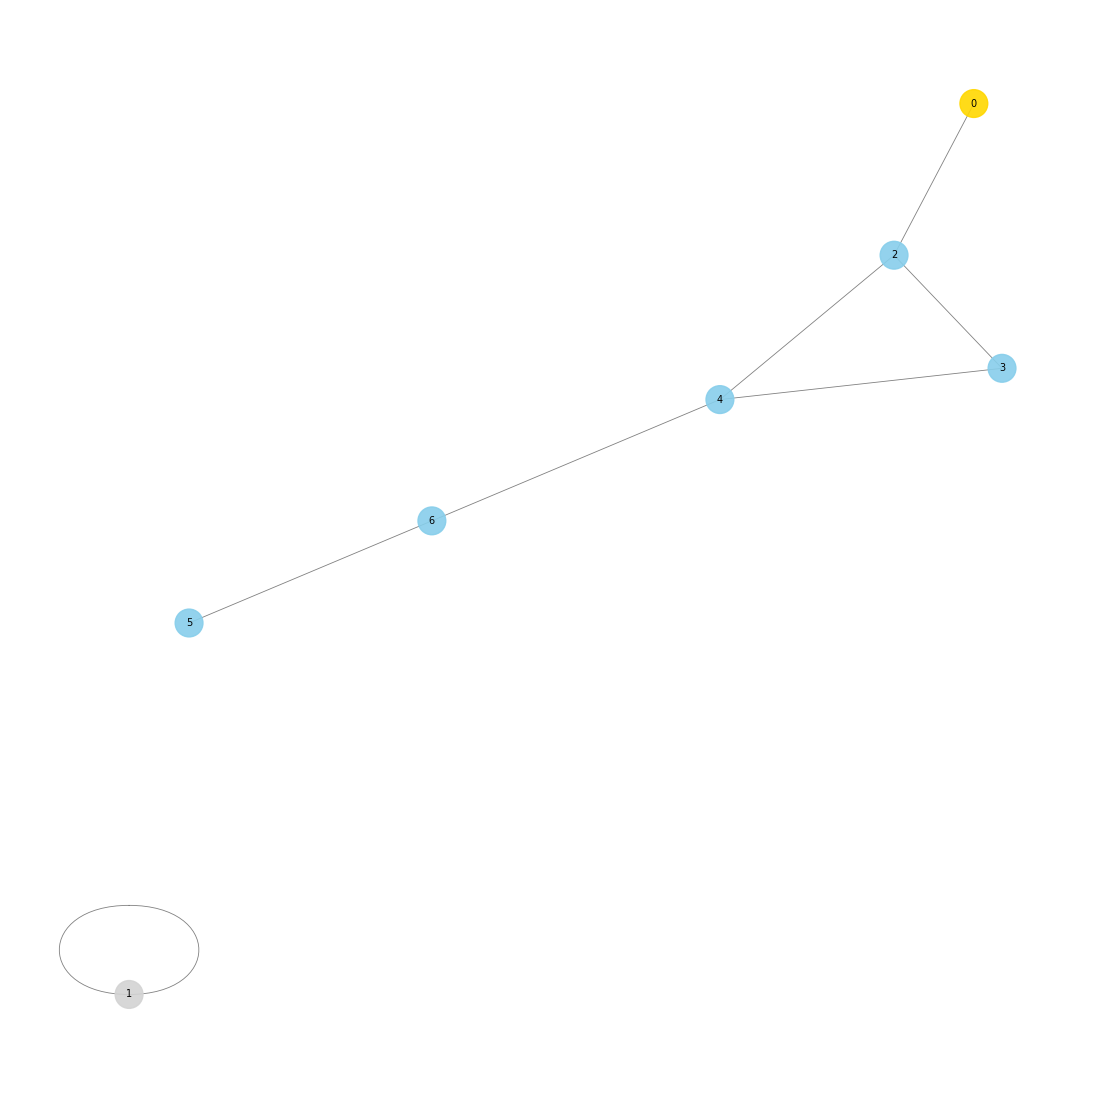

00:24:20.975:aoc2017 - DBG: {0, 2, 3, 4, 5, 6}
00:24:20.978:aoc2017 - INF: Test passed
00:24:20.978:aoc2017 - INF: All tests passed!


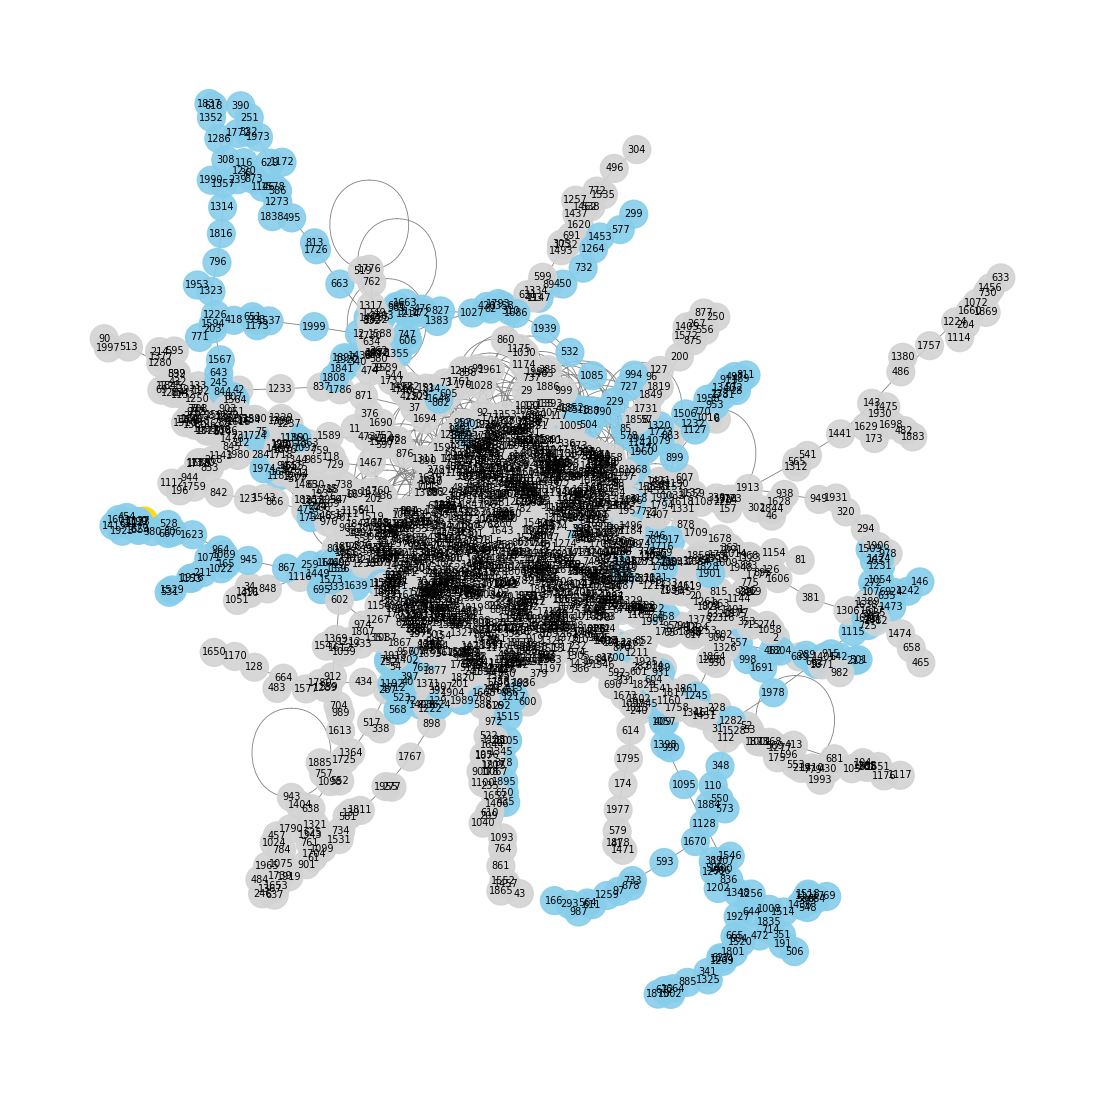

00:24:27.119:aoc2017 - DBG: {0, 12, 28, 33, 36, 54, 59, 70, 72, 82, 85, 94, 97, 110, 114, 116, 132, 140, 146, 148, 154, 155, 158, 164, 165, 166, 172, 179, 183, 188, 191, 203, 211, 213, 229, 233, 239, 245, 251, 252, 254, 255, 259, 260, 263, 272, 273, 282, 289, 291, 293, 299, 303, 308, 310, 313, 321, 322, 324, 331, 332, 333, 340, 341, 347, 348, 351, 361, 362, 378, 380, 386, 387, 390, 393, 397, 409, 415, 418, 420, 435, 438, 450, 454, 458, 462, 469, 472, 476, 489, 495, 497, 501, 503, 504, 506, 512, 518, 523, 526, 528, 529, 531, 532, 536, 537, 548, 550, 557, 560, 564, 566, 568, 572, 573, 577, 578, 580, 593, 606, 611, 618, 621, 627, 629, 635, 642, 643, 644, 650, 651, 662, 663, 665, 667, 672, 673, 678, 680, 684, 685, 693, 695, 696, 699, 707, 714, 725, 727, 732, 733, 747, 750, 763, 769, 771, 781, 790, 795, 796, 804, 806, 807, 811, 813, 827, 836, 844, 847, 867, 873, 885, 886, 899, 907, 911, 915, 917, 922, 924, 925, 929, 931, 935, 945, 953, 956, 964, 984, 987, 990, 993, 994, 998, 1008, 1009, 101

CPU times: user 44.2 s, sys: 525 ms, total: 44.7 s
Wall time: 6.65 s


In [108]:
%%time
sample_inputs = []
sample_inputs.append("""0 <-> 2
1 <-> 1
2 <-> 0, 3, 4
3 <-> 2, 4
4 <-> 2, 3, 6
5 <-> 6
6 <-> 4, 5""")
sample_answers = [6]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1_with_networkx(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1_with_networkx(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 12 Part 2

Okay, so we've found all the programs in the group with program `0`. But what about the others?

It turns out there are more programs in the village, but they're not all connected. A "group" is any collection of programs that can all communicate with each other, directly or indirectly. The programs we found in Part 1 form one of these groups.

Our new task is to figure out **how many distinct groups there are in total.**

Looking back at our sample data we can see two separate groups:

*   One group containing programs `0, 2, 3, 4, 5, 6`.
*   Another group containing just program `1`.

So for this example, the answer would be `2`. We need to apply this logic to our full dataset.

#### Solution Approach

There's a couple of ways we can do this. One way is as follows:

1. From the full set of program IDs, subtract all the program IDs from the program group we've already found (the one that included program ID of `0`). Let's call it `remaining`.
1. Pick an arbitrary ID from `remaining`.
1. BFS with this ID to find its group.
1. Subtract this new group of program IDs from `remaining`, to give us a new `remaining`.
1. Repeat until no more program IDs remain.

Let's try this...

In [ ]:
def solve_part2(data):
    """Count the total number of distinct program groups.

    Iteratively find all connected programs within a group using a Breadth-First Search (BFS)
    and removes them from the pool of unvisited programs. This process continues until
    all programs have been assigned to a group, and the total number of groups is returned.
    """
    # Create adjacency list where keys are program IDs and values are a set of connected program IDs
    graph = create_graph(data) # E.g. {0: [2], 1: [1], 2: [0, 3, 4], ...}
    all_ids = set()
    for prog_id in graph.keys():
        all_ids.add(prog_id)
        
    for id_sets in graph.values():
        all_ids |= id_sets
        
    logger.debug(f"Total ID count: {len(all_ids)}")
    
    groups_found = 0
    while all_ids:
        if 0 in all_ids:
            start = 0
        else:
            start = all_ids.pop()
            
        visited = bfs_for_group(graph, start)
        logger.debug(f"Group found from {start} with len{visited} IDs")
        groups_found += 1
        all_ids.difference_update(visited)
        logger.debug(f"Total ID count: {len(all_ids)}")
    
    return groups_found

In [127]:
%%time
sample_inputs = []
sample_inputs = []
sample_inputs.append("""0 <-> 2
1 <-> 1
2 <-> 0, 3, 4
3 <-> 2, 4
4 <-> 2, 3, 6
5 <-> 6
6 <-> 4, 5""")
sample_answers = [2]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

00:53:58.486:aoc2017 - DBG: Total ID count: 7
00:53:58.487:aoc2017 - DBG: Group found from 0 with len{0, 2, 3, 4, 5, 6} IDs
00:53:58.488:aoc2017 - DBG: Total ID count: 1
00:53:58.488:aoc2017 - DBG: Group found from 1 with len{1} IDs
00:53:58.489:aoc2017 - DBG: Total ID count: 0
00:53:58.489:aoc2017 - INF: Test passed
00:53:58.489:aoc2017 - INF: Tests passed!
00:53:58.501:aoc2017 - DBG: Total ID count: 2000
00:53:58.504:aoc2017 - DBG: Group found from 0 with len{0, 12, 28, 33, 36, 54, 59, 70, 72, 82, 85, 94, 97, 110, 114, 116, 132, 140, 146, 148, 154, 155, 158, 164, 165, 166, 172, 179, 183, 188, 191, 203, 211, 213, 229, 233, 239, 245, 251, 252, 254, 255, 259, 260, 263, 272, 273, 282, 289, 291, 293, 299, 303, 308, 310, 313, 321, 322, 324, 331, 332, 333, 340, 341, 347, 348, 351, 361, 362, 378, 380, 386, 387, 390, 393, 397, 409, 415, 418, 420, 435, 438, 450, 454, 458, 462, 469, 472, 476, 489, 495, 497, 501, 503, 504, 506, 512, 518, 523, 526, 528, 529, 531, 532, 536, 537, 548, 550, 557, 560

CPU times: user 212 ms, sys: 76.9 ms, total: 289 ms
Wall time: 266 ms


Of course, we can just use NetworkX again.

---
## Day n: title

In [ ]:
DAY = "n" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = dc.get_locations(script_name, d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day n Part 1

Overview...

In [30]:
def solve_part1(data):
    pass

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""abcdef""")
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

CPU times: user 0 ns, sys: 1.57 ms, total: 1.57 ms
Wall time: 1.61 ms


AssertionError: None != 6

### Day n Part 2

Overview...

In [ ]:
def solve_part2(data):
    pass

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""abcdef""")
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")